In [21]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torchsummary import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Manipulation

In [23]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [24]:
dataset = datasets.ImageFolder(root="data/Skyfinder/picked", transform=data_transforms)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [25]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
# check shapes of dataloader
feature, label = next(iter(train_dl))
feature.shape, label.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

### Create Model

A VAE is just like an Autoencoder but the latent vector is now represnted as Gaussians

In [27]:
input_dim = 3*64*64
output_dim = input_dim
hidden_dim = 512
latent_dim = 256

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim):
        super(Encoder, self).__init__()

        self.en_input = nn.Linear(input_dim, hidden_dim)
        self.en_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.en_mean = nn.Linear(hidden_dim, latent_dim)
        self.en_var = nn.Linear(hidden_dim, latent_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.en_input(x)
        x = self.relu(x)

        x = self.en_hidden(x)
        x = self.relu(x)

        mean = self.en_mean(x) # means and variance under log
        var = self.en_var(x)

        return mean, var

In [29]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim):
        super(Decoder, self).__init__()

        self.de_input = nn.Linear(latent_dim, hidden_dim)
        self.de_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.de_out = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.de_input(x)
        x = self.relu(x)

        x = self.de_hidden(x)
        x = self.relu(x)

        x = self.de_out(x)
        x = torch.sigmoid(x)

        return x

In [30]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()

        self.Encoder = Encoder
        self.Decoder = Decoder

    def rep(self, mean, var):
        e = torch.randn_like(var).to(device)
        z = mean + var * e
        return z
    
    def forward(self, x):
        mean, var = self.Encoder(x)
        z = self.rep(mean, torch.exp(0.5 * var)) # log var -> var
        x = self.Decoder(z)

        return x, mean, var

encoder = Encoder()
decoder = Decoder()
model = VAE(Encoder=encoder, Decoder=decoder).to(device)

summary(model, (16, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 512]       6,291,968
              ReLU-2              [-1, 16, 512]               0
            Linear-3              [-1, 16, 512]         262,656
              ReLU-4              [-1, 16, 512]               0
            Linear-5              [-1, 16, 256]         131,328
            Linear-6              [-1, 16, 256]         131,328
           Encoder-7  [[-1, 16, 256], [-1, 16, 256]]               0
            Linear-8              [-1, 16, 512]         131,584
              ReLU-9              [-1, 16, 512]               0
           Linear-10              [-1, 16, 512]         262,656
             ReLU-11              [-1, 16, 512]               0
           Linear-12            [-1, 16, 12288]       6,303,744
          Decoder-13            [-1, 16, 12288]               0
Total params: 13,515,264
Trainable

### Optimizer and Custom Loss Function

In [31]:
def loss_fn(x, x_hat, mean, log_var):

    # loss for reproduction
    bce = nn.BCELoss(reduction="sum")
    rep_loss = bce(x_hat, x)

    # loss for comparing distributions (Kullback–Leibler divergence)
    kld = -0.5 *  torch.sum(1+log_var-mean.pow(2)-log_var.exp())

    return rep_loss + kld

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training Model

In [32]:
torch.manual_seed(42)

epochs = 30

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        if X.shape[0] != 16:
            continue

        X, y = X.view(batch_size, input_dim).to(device), y.to(device)

        # forward pass
        train_x_hat, train_mean, train_log_var = model(X)

        # metrics
        loss = loss_fn(X, train_x_hat, train_mean, train_log_var)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            if X.shape[0] != 16:
                continue

            X, y = X.view(batch_size, input_dim).to(device), y.to(device)

            # forward pass
            test_x_hat, test_mean, test_var = model(X)

            # metrics
            test_loss += loss_fn(X, test_x_hat, test_mean, test_var)

        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
------


  3%|▎         | 1/30 [00:01<00:33,  1.17s/it]

Train Loss: 119697.0781
Test Loss: 91865.2500
Epoch: 1
------


  7%|▋         | 2/30 [00:02<00:28,  1.01s/it]

Train Loss: 110758.2812
Test Loss: 83908.8594
Epoch: 2
------


 10%|█         | 3/30 [00:02<00:26,  1.03it/s]

Train Loss: 105282.6094
Test Loss: 81662.5781
Epoch: 3
------


 13%|█▎        | 4/30 [00:03<00:23,  1.08it/s]

Train Loss: 103617.7344
Test Loss: 82151.3438
Epoch: 4
------


 17%|█▋        | 5/30 [00:04<00:22,  1.12it/s]

Train Loss: 102082.9375
Test Loss: 79392.3125
Epoch: 5
------


 20%|██        | 6/30 [00:05<00:21,  1.12it/s]

Train Loss: 101177.7031
Test Loss: 79384.0703
Epoch: 6
------


 23%|██▎       | 7/30 [00:06<00:20,  1.13it/s]

Train Loss: 99680.2344
Test Loss: 78879.5938
Epoch: 7
------


 27%|██▋       | 8/30 [00:07<00:19,  1.15it/s]

Train Loss: 98943.4375
Test Loss: 77625.4375
Epoch: 8
------


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

Train Loss: 98234.6875
Test Loss: 77811.1719
Epoch: 9
------


 33%|███▎      | 10/30 [00:08<00:15,  1.27it/s]

Train Loss: 98857.8203
Test Loss: 77875.4375
Epoch: 10
------


 37%|███▋      | 11/30 [00:09<00:14,  1.33it/s]

Train Loss: 98749.7266
Test Loss: 76688.0625
Epoch: 11
------


 40%|████      | 12/30 [00:10<00:13,  1.37it/s]

Train Loss: 97076.2188
Test Loss: 75385.4531
Epoch: 12
------


 43%|████▎     | 13/30 [00:10<00:12,  1.40it/s]

Train Loss: 96349.8281
Test Loss: 76752.7188
Epoch: 13
------


 47%|████▋     | 14/30 [00:11<00:11,  1.40it/s]

Train Loss: 95941.0547
Test Loss: 74533.2578
Epoch: 14
------


 50%|█████     | 15/30 [00:12<00:10,  1.42it/s]

Train Loss: 95015.3438
Test Loss: 74582.9609
Epoch: 15
------


 53%|█████▎    | 16/30 [00:12<00:09,  1.45it/s]

Train Loss: 95118.3125
Test Loss: 75120.5312
Epoch: 16
------


 57%|█████▋    | 17/30 [00:13<00:08,  1.47it/s]

Train Loss: 95110.6641
Test Loss: 75657.2188
Epoch: 17
------


 60%|██████    | 18/30 [00:14<00:08,  1.46it/s]

Train Loss: 94989.0938
Test Loss: 74798.0625
Epoch: 18
------


 63%|██████▎   | 19/30 [00:14<00:07,  1.46it/s]

Train Loss: 94092.4688
Test Loss: 75075.4688
Epoch: 19
------


 67%|██████▋   | 20/30 [00:15<00:06,  1.48it/s]

Train Loss: 94351.7656
Test Loss: 74360.2344
Epoch: 20
------


 70%|███████   | 21/30 [00:16<00:06,  1.48it/s]

Train Loss: 94399.7891
Test Loss: 74013.3594
Epoch: 21
------


 73%|███████▎  | 22/30 [00:16<00:05,  1.46it/s]

Train Loss: 94103.1406
Test Loss: 73290.7734
Epoch: 22
------


 77%|███████▋  | 23/30 [00:17<00:04,  1.48it/s]

Train Loss: 94590.1797
Test Loss: 73721.5625
Epoch: 23
------


 80%|████████  | 24/30 [00:18<00:04,  1.50it/s]

Train Loss: 94245.4531
Test Loss: 73827.6250
Epoch: 24
------


 83%|████████▎ | 25/30 [00:18<00:03,  1.51it/s]

Train Loss: 93639.2266
Test Loss: 73846.2812
Epoch: 25
------


 87%|████████▋ | 26/30 [00:19<00:02,  1.52it/s]

Train Loss: 93330.5781
Test Loss: 73943.5391
Epoch: 26
------


 90%|█████████ | 27/30 [00:20<00:02,  1.49it/s]

Train Loss: 93352.9844
Test Loss: 75744.7500
Epoch: 27
------


 93%|█████████▎| 28/30 [00:20<00:01,  1.47it/s]

Train Loss: 94489.7188
Test Loss: 73807.3750
Epoch: 28
------


 97%|█████████▋| 29/30 [00:21<00:00,  1.45it/s]

Train Loss: 93973.1016
Test Loss: 73314.5000
Epoch: 29
------


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

Train Loss: 94483.8906
Test Loss: 73664.5391


### Testing Model

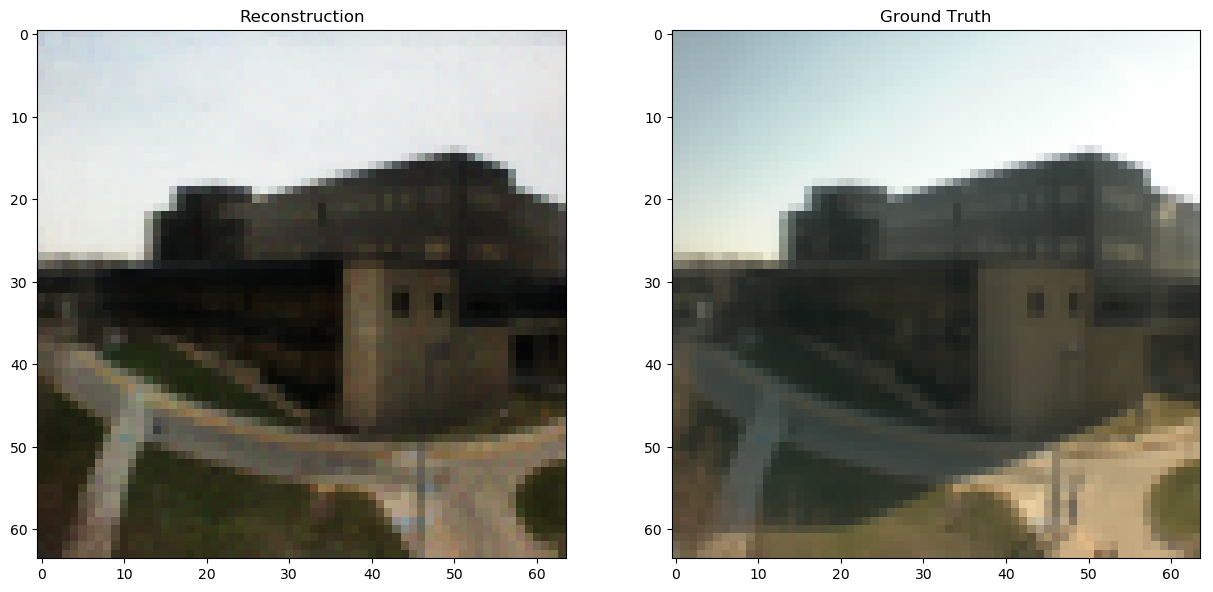

In [37]:
X, y = next(iter(train_dl))
X, y = X[0, :, :].view(input_dim).to(device), y[0].to(device)

sample_reconst, sample_mean, sample_var = model(X)
sample_reconst = sample_reconst.reshape(3, 64, 64).permute(1, 2, 0).detach().cpu().numpy()

X_img = X.reshape(3, 64, 64).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.title("Reconstruction")
plt.imshow(sample_reconst)

plt.subplot(122)
plt.title("Ground Truth")
plt.imshow(X_img)